In [2]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
from low_rank_rnns import rdm, romo, mante, dms, clustering, helpers, raposo
from low_rank_rnns import mante_regressions as mreg
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, homogeneity_score, r2_score
from scipy import stats

In [15]:
helpers.setup_matplotlib(release=True)
plt.rcParams['axes.linewidth'] = .5

In [7]:
hidden_size = 2048
noise_std = 0
alpha = 0.2

x_train, y_train, mask_train, x_val, y_val, mask_val = raposo.generate_data(1000)
net = LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/raposo_rank1_{hidden_size}.pt'))
loss_orig, acc_orig = raposo.test(net, x_val, y_val, mask_val)
print(acc_orig)

0.9399999976158142


In [8]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi_full[0].detach().numpy()
wi2 = net.wi_full[1].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

In [9]:
# Computing all regressors

cohs = [-16, -8, -4, -2, -1, 1, 2, 4, 8, 16]
lc2 = len(cohs)**2
inputs = torch.zeros((3 * lc2, raposo.total_duration, 2))

cohs1 = []
cohs2 = []
for k, ctx in enumerate((-1, 0, 1)):
    for i, coh1 in enumerate(cohs):
        for j, coh2 in enumerate(cohs):
            trial_idx = k*lc2 + i*len(cohs) + j
            if ctx in (1, 0):
                inputs[trial_idx, raposo.stim_begin:raposo.stim_end, 0] = coh1 * raposo.SCALE
                cohs1.append(coh1)
            else:
                cohs1.append(0)
            if ctx in (-1, 0):
                inputs[trial_idx, raposo.stim_begin:raposo.stim_end, 1] = coh2 * raposo.SCALE
                cohs2.append(coh2)
            else:
                cohs2.append(0)
ctx1 = [0] * lc2 + [1] * (2 * lc2)
ctx2 = [1] * (2 * lc2) + [0] * lc2

output, trajectories = net.forward(inputs, return_dynamics=True)
output = output.detach().squeeze().numpy()
trajectories = trajectories.detach().numpy()
rates = np.tanh(trajectories)
choices = np.sign(np.mean(output[:, raposo.response_begin:], axis=1))

target = np.mean(rates[:, raposo.stim_begin:raposo.stim_begin + 10, :], axis=1)
predictors = np.stack([np.array(cohs1) / 16, np.array(cohs2) / 16]).T
print(target.shape)
print(predictors.shape)
reg_sens = LinearRegression(fit_intercept=False).fit(predictors, target)
target_hat = reg_sens.predict(predictors)
print(r2_score(target, target_hat))

target = np.mean(rates[:, raposo.response_begin:, :], axis=1)
predictors = choices.reshape((-1, 1))
reg_choice = LinearRegression(fit_intercept=False).fit(predictors, target)
target_hat = reg_choice.predict(predictors)
print(r2_score(target, target_hat))
reg_full = np.hstack([reg_sens.coef_, reg_choice.coef_])

(300, 2048)
(300, 2)
0.98940642201704
0.9093186684498988


Text(0, 0.9, '$\\beta_i^A$')

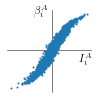

In [11]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.scatter(wi1, reg_full[:, 0], zorder=100, s=1)
ax.set(xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$I_i^A$', horizontalalignment='right', x=1)
ax.set_ylabel('$\\beta_i^A$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_raposo_IArA.pdf', bbox_inches='tight')

Text(0, 0.9, '$\\beta_i^{choice}$')

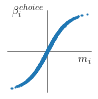

In [12]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.scatter(m, reg_full[:, 2], zorder=100, s=1)
ax.set(xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$m_i$', horizontalalignment='right', x=1)
ax.set_ylabel('$\\beta_i^{choice}$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_raposo_mrchoice.pdf', bbox_inches='tight')

Text(0, 0.9, '$\\beta_i^B$')

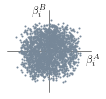

In [13]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.scatter(reg_full[:, 0], reg_full[:, 1], zorder=100, s=1, c='lightslategray')
ax.set(xticks=[], yticks=[], xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$\\beta_i^A$', horizontalalignment='right', x=1.1)
ax.set_ylabel('$\\beta_i^B$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_raposo_rarb.pdf', bbox_inches='tight')

Text(0, 0.9, '$\\beta_i^{choice}$')

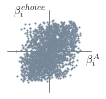

In [14]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.scatter(reg_full[:, 0], reg_full[:, 2], zorder=1000, s=1, c='lightslategray')
ax.set(xticks=[], yticks=[], xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$\\beta_i^A$', horizontalalignment='right', x=1.1)
ax.set_ylabel('$\\beta_i^{choice}$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_raposo_rarchoice.pdf', bbox_inches='tight')

Warning: cell below makes heavy computations

In [21]:
%%time
clusters_nums = (2, 3, 4, 5, 6)
aris = [clustering.clustering_stability(reg_full, k, 20, algo='gmm') for k in clusters_nums]

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or

CPU times: user 3.23 s, sys: 205 ms, total: 3.44 s
Wall time: 3min 3s


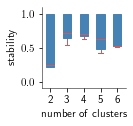

In [27]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
clustering.boxplot_clustering_stability(reg_full, clusters_nums, aris=aris, ax=ax)
#plt.savefig('figures/5_raposo_stab.eps', bbox_inches='tight')